In [34]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
import joblib
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization, LSTM, Bidirectional, Activation, GRU, SpatialDropout1D

In [35]:
file_path = 'CyberThreatData.csv'
data = pd.read_csv(file_path)

In [36]:
data.head(10)

,Unnamed: 0,id,Tweet,tag,Classification,Subjectivity,Polarity,Analysis
0,0,1.540000e+18,"['Cloudflare', 'affirme', 'avoir', 'réussi', '...",DDoS,1,0.000000,0.000000,Neutral
1,1,1.540000e+18,"['using', 'Ukrainian', 'Telegram', 'bot', 'lau...",DDoS,2,0.000000,0.000000,Neutral
2,2,1.540000e+18,"['Cloudflare', 'affirme', 'avoir', 'réussi', '...",DDoS,2,0.000000,0.000000,Neutral
3,3,1.540000e+18,"['Cloudflare', 'affirme', 'avoir', 'réussi', '...",DDoS,2,0.000000,0.000000,Neutral
4,4,1.540000e+18,"['Cloudflare', 'affirme', 'avoir', 'réussi', '...",DDoS,2,0.000000,0.000000,Neutral
5,5,1.540000e+18,"['Since', 'yesterday', 'started', 'massive', '...",DDoS,2,1.000000,0.000000,Neutral
6,6,1.540000e+18,"['Today', 'day', 'I’ve', 'looking', 'much', 'f...",DDoS,2,0.330000,0.098750,Positive
7,7,1.540000e+18,"['accurately', 'determine', 'risk', 'DDoS', 'a...",DDoS,1,0.611111,0.633333,Positive
8,8,1.540000e+18,"['DDoS', 'weapons', 'rise', 'new', 'research',...",DDoS,1,0.477273,0.318182,Positive
9,9,1.540000e+18,"['DDoS', 'weapons', 'rise', 'new', 'research',...",DDoS,1,0.477273,0.318182,Positive


In [37]:
lemmatizer = WordNetLemmatizer()
# Function to clean and preprocess text
def preprocess_text(text):
    # Remove special characters and links
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    
    return ' '.join(tokens)

data['cleaned_tweet'] = data['Tweet'].apply(preprocess_text)

In [38]:
data.head(5)

,Unnamed: 0,id,Tweet,tag,Classification,Subjectivity,Polarity,Analysis,cleaned_tweet
0,0,1.540000e+18,"['Cloudflare', 'affirme', 'avoir', 'réussi', '...",DDoS,1,0.0,0.0,Neutral,cloudflare affirme avoir russi attnuer une att...
1,1,1.540000e+18,"['using', 'Ukrainian', 'Telegram', 'bot', 'lau...",DDoS,2,0.0,0.0,Neutral,using ukrainian telegram bot launch ddos attac...
2,2,1.540000e+18,"['Cloudflare', 'affirme', 'avoir', 'réussi', '...",DDoS,2,0.0,0.0,Neutral,cloudflare affirme avoir russi attnuer une att...
3,3,1.540000e+18,"['Cloudflare', 'affirme', 'avoir', 'réussi', '...",DDoS,2,0.0,0.0,Neutral,cloudflare affirme avoir russi attnuer une att...
4,4,1.540000e+18,"['Cloudflare', 'affirme', 'avoir', 'réussi', '...",DDoS,2,0.0,0.0,Neutral,cloudflare affirme avoir russi attnuer une att...


In [39]:
max_words = 5000
max_len = 100

In [40]:
print(data['Analysis'].value_counts())

Neutral     1416
Positive     842
Negative     313
Name: Analysis, dtype: int64


In [41]:
X = data['cleaned_tweet'].tolist()
y = data['Analysis'].values

In [42]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

In [49]:
print(y)

[1 1 1 ... 1 1 1]


In [50]:
tokenizer = Tokenizer(num_words = max_words, oov_token = "<OOV>")
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen = max_len, padding = 'post')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.2, random_state = 42)

In [52]:
import zipfile
import os

zip_file_path = 'GoogleNews-vectors-negative300.bin.zip'

zip_dir = os.path.dirname(zip_file_path)

with zipfile.ZipFile(zip_file_path) as zip_ref:
    zip_ref.extractall(zip_dir)

In [53]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

In [54]:
embedding_dim = 300

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[index] = word2vec_model[word]

In [55]:
num_classes = len(np.unique(y))

model_RNN = Sequential([
    Embedding(input_dim = len(tokenizer.word_index) + 1, 
             output_dim = embedding_dim,
             weights = [embedding_matrix],
             input_length = max_len,
             trainable = True),
    Bidirectional(SimpleRNN(128, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(32, return_sequences = False, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])

model_RNN.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.005),
                 metrics = ['accuracy'])
model_RNN.build(input_shape = (None, max_len))
model_RNN.summary()

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 300)            │       2,210,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 100, 256)            │         109,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 100, 128)            │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,389,027 (9.11 MB)

 Trainable params: 2,389,027 (9.11 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history_RNN = model_RNN.fit(X_train, y_train, epochs = 50, batch_size = 32,
                           validation_data = (X_test, y_test))

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.4928 - loss: 2.9881 - val_accuracy: 0.5573 - val_loss: 0.9804
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.5617 - loss: 0.9892 - val_accuracy: 0.6214 - val_loss: 0.9744
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.6348 - loss: 0.9800 - val_accuracy: 0.6544 - val_loss: 0.8412
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.7208 - loss: 0.8187 - val_accuracy: 0.7126 - val_loss: 0.9058
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7625 - loss: 0.9021 - val_accuracy: 0.6990 - val_loss: 1.0808
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.7497 - loss: 0.9344 - val_accuracy: 0.7359 - val_loss: 2.5454
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.7846 - loss: 2.1058 - val_accuracy: 0.7029 - val_loss: 1.4306
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.7801 - loss: 1.1668 - val_accuracy

In [57]:
import pickle

with open('english_history_RNN.pkl', 'wb') as f:
    pickle.dump(history_RNN.history, f)

In [59]:
with open('english_history_RNN.pkl', 'rb') as f:
    loaded_RNN_history = pickle.load(f)

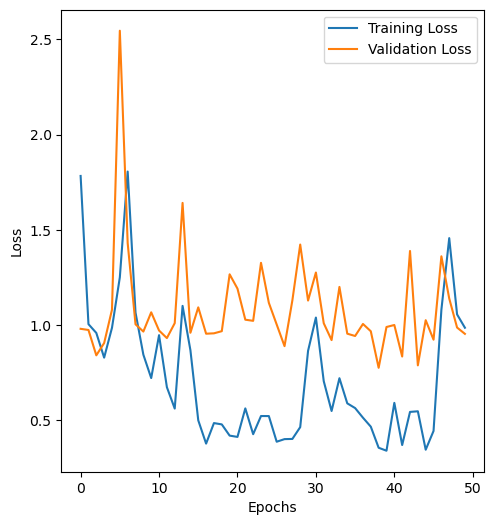

In [60]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(loaded_RNN_history['loss'], label = 'Training Loss')
plt.plot(loaded_RNN_history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

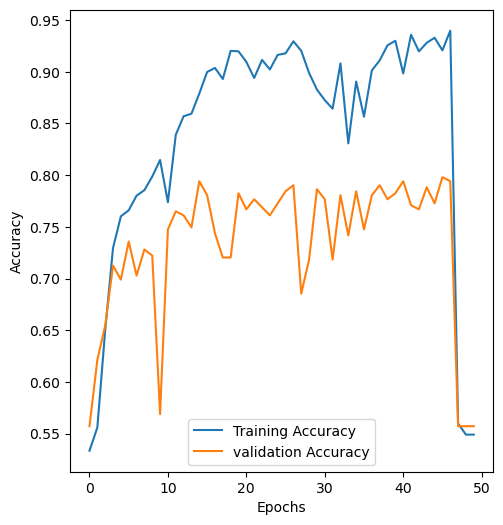

In [61]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
plt.plot(loaded_RNN_history['accuracy'], label = 'Training Accuracy')
plt.plot(loaded_RNN_history['val_accuracy'], label =  'validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [62]:
num_classes = len(np.unique(y))
model_lstm = Sequential([
    Embedding(input_dim = len(tokenizer.word_index) +1, output_dim = embedding_dim,
             weights = [embedding_matrix],
             input_length = max_len,
             trainable = True),
    Bidirectional(LSTM(128, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(128, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(LSTM(32, return_sequences = False, kernel_regularizer = l2(0.01))),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])
model_lstm.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.0005), metrics = ['accuracy'])
model_lstm.build(input_shape= (None, max_len))
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 300)            │       2,210,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 100, 256)            │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 100, 128)            │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 100, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,507 (10.55 MB)

 Trainable params: 2,765,507 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history_lstm = model_lstm.fit(X_train, y_train,
                             epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.4866 - loss: 10.4076 - val_accuracy: 0.5728 - val_loss: 5.9088
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.5807 - loss: 5.0342 - val_accuracy: 0.7403 - val_loss: 2.9416
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.7333 - loss: 2.5742 - val_accuracy: 0.7961 - val_loss: 1.6314
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.8627 - loss: 1.3656 - val_accuracy: 0.7985 - val_loss: 1.1651
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.9274 - loss: 0.8295 - val_accuracy: 0.8301 - val_loss: 0.9128
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.9587 - loss: 0.5437 - val_accuracy: 0.8422 - val_loss: 0.8012
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.9776 - loss: 0.3717 - val_accuracy: 0.8447 - val_loss: 0.7471
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9776 - loss: 0.2955 - val_accuracy

In [64]:
import pickle

with open('english_history_LSTM.pkl', 'wb') as f:
    pickle.dump(history_lstm.history, f)

In [65]:
with open('english_history_LSTM.pkl', 'rb') as f:
    loaded_LSTM_history = pickle.load(f)

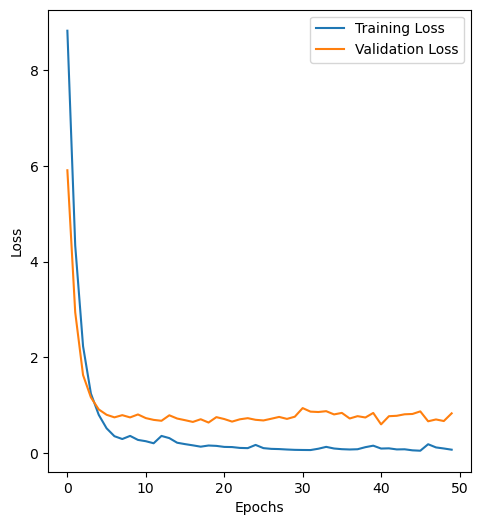

In [68]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(loaded_LSTM_history['loss'], label = 'Training Loss')
plt.plot(loaded_LSTM_history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

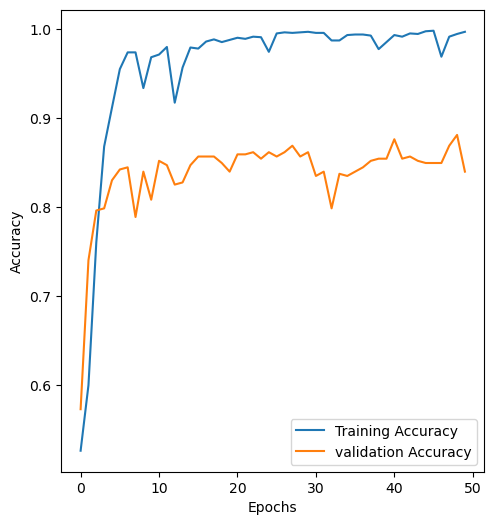

In [69]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
plt.plot(loaded_LSTM_history['accuracy'], label = 'Training Accuracy')
plt.plot(loaded_LSTM_history['val_accuracy'], label =  'validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [70]:
num_classes = len(np.unique(y))

model_GRU = Sequential([
    Embedding(input_dim = len(tokenizer.word_index)+1,
             output_dim = embedding_dim,
             weights = [embedding_matrix],
             input_length = max_len,
             trainable = True),
    Bidirectional(GRU(128, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(64, return_sequences = True, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Bidirectional(GRU(32, return_sequences = False, kernel_regularizer = l2(0.01))),
    Dense(32, activation = 'relu'),
    Dropout(0.4),
    Dense(num_classes, activation = 'softmax')
])

model_GRU.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.001),
                 metrics = ['accuracy'])
model_GRU.build(input_shape = (None, max_len))
model_GRU.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 300)            │       2,210,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 100, 256)            │         330,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 100, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 100, 128)            │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 100, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 64)                  │          12,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,605,475 (9.94 MB)

 Trainable params: 2,605,475 (9.94 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history_GRU = model_GRU.fit(X_train, y_train, validation_data = (X_test, y_test),
                           epochs = 50,
                           batch_size = 32)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.5704 - loss: 6.8584 - val_accuracy: 0.7534 - val_loss: 1.8944
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.7879 - loss: 1.5452 - val_accuracy: 0.8194 - val_loss: 0.8472
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - accuracy: 0.8481 - loss: 0.7194 - val_accuracy: 0.8311 - val_loss: 0.6501
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.9215 - loss: 0.4206 - val_accuracy: 0.8408 - val_loss: 0.5640
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.9317 - loss: 0.3433 - val_accuracy: 0.8214 - val_loss: 0.6764
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.9599 - loss: 0.2381 - val_accuracy: 0.8447 - val_loss: 0.6512
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.9663 - loss: 0.2461 - val_accuracy: 0.8466 - val_loss: 0.6538
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 224ms/step - accuracy: 0.9709 - loss: 0.2233 - val_accu

In [72]:
with open('gru_english_history.pkl', 'wb') as f:
    pickle.dump(history_GRU.history, f)

In [73]:
with open('gru_english_history.pkl', 'rb') as f:
    loaded_GRU_history = pickle.load(f)

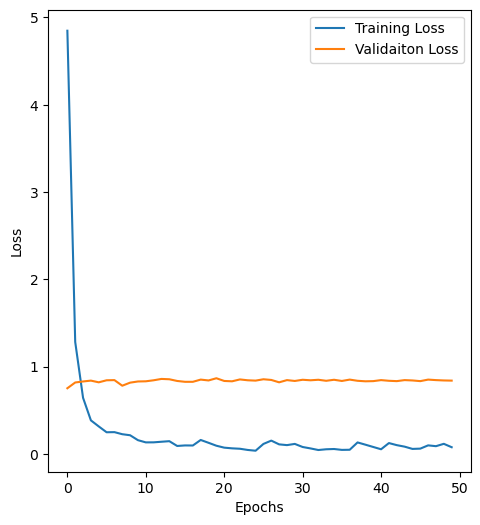

In [74]:
plt.figure(figsize =(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loaded_GRU_history['loss'], label = 'Training Loss')
plt.plot(loaded_GRU_history['val_accuracy'], label = 'Validaiton Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

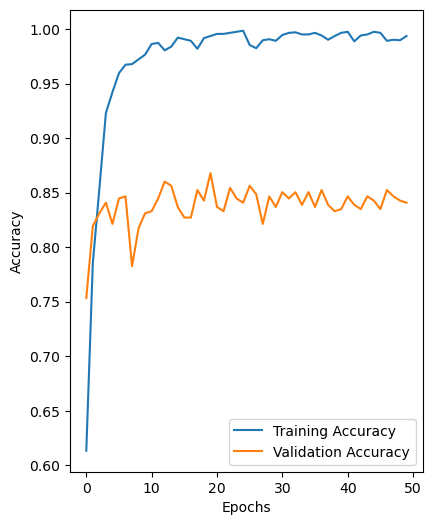

In [75]:
plt.figure(figsize = (10,6))
plt.subplot(1, 2, 2)
plt.plot(loaded_GRU_history['accuracy'], label = 'Training Accuracy')
plt.plot(loaded_GRU_history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()